In [123]:
import pandas as pd
import os
import plotting
import importlib
importlib.reload(plotting)
import math
from typing import List
pd.options.display.max_rows = 4000

In [124]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

In [125]:
data_features = pd.read_csv("data/features.csv")
data_features = plotting.extract_needed_cols(data_features, remove_cols=['feifeis_ylabels', 'liams_ylabels', 'distances'])
clustering_features = plotting.extract_numerical_features(data_features)


ylabel_name = 'marions_ylabels'
# ylabel_name = 'marions_ylabels_deduction'
ylabel_to_cluster_num = {'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
marions_labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data
print(f'marions_labeled_data: \n{marions_labeled_data[:3]}')

marions_labeled_data: 
    max_depth  max_resistance  num_peaks  largest_force_drop  \
1   -0.254598        0.796618  -0.611243           -0.590691   
5    0.726243       -0.320638  -0.611243            0.147195   
11  -0.557686        0.891192  -0.611243           -0.831937   

    largest_force_drop_dep  largest_force_drop_res  curve_shape  \
1                 0.796741                1.595513     0.856677   
5                 0.954790               -0.171830    -0.723789   
11                0.446165                1.669219     1.083126   

    first_quarter_slope  second_quarter_slope  third_quarter_slope  \
1             -0.089595              0.115582            -0.343113   
5             -0.511873             -0.436533            -0.522921   
11             0.555511              0.005249            -0.319281   

    fourth_quarter_slope  quartile_1  quartile_3      skew  kurtosis  \
1              -0.374077    0.693792    1.013663 -0.761611 -0.609501   
5              -0.406242  

In [126]:
def find_labels_centroids(labeled_data: pd.DataFrame, ylabel_to_cluster_num:dict[str,int], ylabel_name:str) -> pd.DataFrame:
    labeled_data = labeled_data.copy()
    numerical_data = plotting.extract_numerical_features(labeled_data)
    label_centroids = []
    for label, label_num in ylabel_to_cluster_num.items():
        if label not in labeled_data[ylabel_name].values: continue
        label_data = numerical_data[labeled_data[ylabel_name] == label]
        label_centroid = label_data.mean(axis=0).tolist() # drop cols for mean calculation
        label_centroid.extend([label, label_num]) # append these onto the end
        label_centroids.append(label_centroid)
    return_cols = numerical_data.columns.tolist()
    return_cols.extend([ylabel_name, f'{ylabel_name}_nums'])
    return pd.DataFrame(data=label_centroids, columns=return_cols)

label_centroids = find_labels_centroids(marions_labeled_data, ylabel_to_cluster_num, ylabel_name)
print(f'label_centroids: \n{label_centroids[:3]}')

label_centroids: 
   max_depth  max_resistance  num_peaks  largest_force_drop  \
0   0.646917       -0.850950   0.965241            1.440089   
1   1.243855       -0.937649   1.223693            1.577089   
2   0.373485       -0.075908  -0.027990           -0.360126   

   largest_force_drop_dep  largest_force_drop_res  curve_shape  \
0               -0.141065               -0.303260    -0.107294   
1               -0.817447               -0.873533    -1.058450   
2                0.454614               -0.196169     0.739768   

   first_quarter_slope  second_quarter_slope  third_quarter_slope  \
0            -0.496666             -0.333546            -0.512763   
1            -0.610143             -0.552341            -0.511080   
2            -0.331226             -0.289928            -0.198757   

   fourth_quarter_slope  quartile_1  quartile_3      skew  kurtosis  \
0             -0.588977   -0.474222   -0.563892 -0.142604 -0.165418   
1             -0.318558   -0.820126   -1.3056

In [127]:
def euclidean_distance(x: pd.Series, y: pd.Series) -> float:
    return math.sqrt(((y - x) ** 2).sum())

def find_closest_centroid(unlabeled_data:pd.DataFrame, marions_centroids:pd.DataFrame, ylabel_name) -> pd.DataFrame:
    unlabeled_num_data = plotting.extract_numerical_features(unlabeled_data) # returns a new object
    unlabeled_non_num_data = unlabeled_data.drop(unlabeled_num_data.columns, axis=1)
    
    pseudo_label_list = []
    pseudo_label_num_list = []
    for i, depth_res_curve in unlabeled_num_data.iterrows():
        min_distance = float('inf')
        min_distance_label = ''
        min_distance_label_num = 0
        for j, marions_label_centroid in marions_centroids.iterrows():
            curve_to_label_mean_distance = euclidean_distance(depth_res_curve, marions_label_centroid)
            if curve_to_label_mean_distance < min_distance:
                min_distance = curve_to_label_mean_distance
                min_distance_label = marions_label_centroid[ylabel_name]
                min_distance_label_num = marions_label_centroid[f'{ylabel_name}_nums']
        pseudo_label_list.append(min_distance_label)
        pseudo_label_num_list.append(min_distance_label_num)
    unlabeled_num_data[f'pseudo_{ylabel_name}'] = pseudo_label_list
    unlabeled_num_data[f'pseudo_{ylabel_name}_nums'] = pseudo_label_num_list

    return pd.concat([unlabeled_num_data, unlabeled_non_num_data], axis=1)

pseudo_labeled_data = find_closest_centroid(data_features, label_centroids, ylabel_name)
print(f'pseudo_labeled_data: \n{pseudo_labeled_data[:3]}')

pseudo_labeled_data: 
   max_depth  max_resistance  num_peaks  largest_force_drop  \
0  -0.530264        0.142229  -0.611243           -0.733451   
1  -0.254598        0.796618  -0.611243           -0.590691   
2  -1.448135        0.151824  -0.611243           -0.913500   

   largest_force_drop_dep  largest_force_drop_res  curve_shape  \
0               -0.744029               -1.065504    -0.563813   
1                0.796741                1.595513     0.856677   
2               -0.707657                1.092997     0.403061   

   first_quarter_slope  second_quarter_slope  third_quarter_slope  ...  \
0            -0.434273             -0.114206            -0.349373  ...   
1            -0.089595              0.115582            -0.343113  ...   
2             2.289283              2.182185             1.387246  ...   

   quartile_1  quartile_3      skew  kurtosis  pseudo_marions_ylabels  \
0   -0.698081   -0.458930  0.620916 -0.120565                    LS/F   
1    0.693792    

In [128]:
def find_changed_ylabel_data(labeled_data:pd.DataFrame, pseudo_labeled_data:pd.DataFrame, ylabel_name:str):
    ylabel_idxs = labeled_data.index # idxs of labeled data points
    pseudo_labels_of_labeled_data = pseudo_labeled_data.loc[ylabel_idxs]
    diff_mask = (labeled_data[ylabel_name] != pseudo_labels_of_labeled_data[f'pseudo_{ylabel_name}'])
    changed_label_idxs = labeled_data[diff_mask].index.tolist()
    for i in changed_label_idxs:
        print(f'idx {i}: {labeled_data['filenames'].loc[i]} changed label {labeled_data[f'{ylabel_name}'].loc[i]} -> {pseudo_labeled_data[f'pseudo_{ylabel_name}'].loc[i]}')
    return changed_label_idxs

changed_ylabel_idxs = find_changed_ylabel_data(marions_labeled_data, pseudo_labeled_data, ylabel_name)
# print(f'changed_ylabel_idxs: {changed_ylabel_idxs}')

idx 1: WS23_L3_T1_P_16.csv changed label ES-B -> F
idx 16: WS23_L2_T1_P_14.csv changed label ES-S -> F
idx 17: WS23_L2_T1_P_12.csv changed label ES-S -> LS/F
idx 19: WS23_L2_T1_P_9.csv changed label ES-S -> LS
idx 21: WS23_L2_T1_P_13.csv changed label ES-D -> ES
idx 24: WS23_L2_T1_P_6.csv changed label ES-D -> LS
idx 34: WS23_L3_T1_P_17.csv changed label ES -> F
idx 36: WS23_L2_T1_P_5.csv changed label ES-D -> ES-S-Plates
idx 46: WS23_L2_T1_P_10.csv changed label ES-D -> F
idx 51: WS23_L3_T1_P_15.csv changed label ES-D -> ES
idx 55: WS23_L3_T1_P_1.csv changed label ES-B -> ES-S-Plates
idx 57: WS23_L3_T1_P_0.csv changed label LS -> ES-BW
idx 61: WS23_L2_T1_P_1.csv changed label LS -> ES-S-Plates
idx 65: WS23_L2_T1_P_3.csv changed label ES-D -> ES-S
idx 74: WS23_L3_T1_P_5.csv changed label ES-B -> ES-BW
idx 75: WS23_L2_T1_P_15.csv changed label ES-D -> ES
idx 76: WS23_L3_T1_P_14.csv changed label ES-D -> ES-BW
idx 85: WS23_L3_T1_P_23.csv changed label LS -> ES-BW
idx 86: WS23_L3_T1_P_7.c

# Plot Labeled Data Only

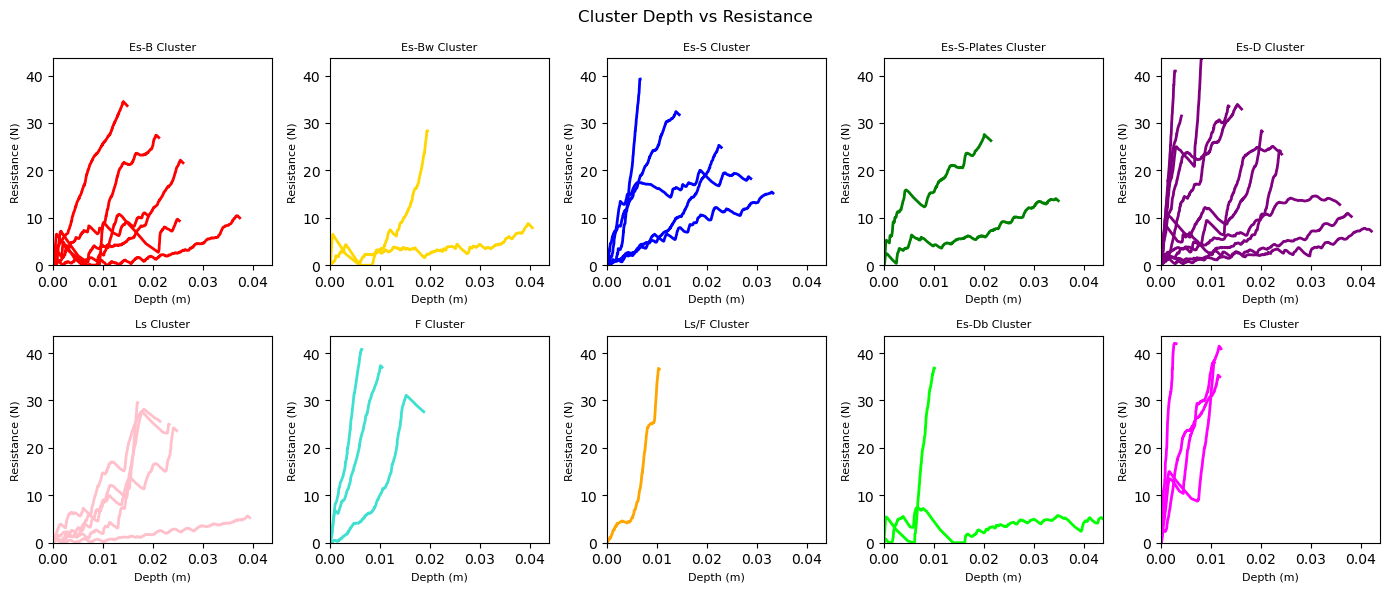

In [129]:

plotting.plot_clusters_seperately(marions_labeled_data[f'{ylabel_name}_nums'], curve_data, ylabel_name,
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  bold_idxs=marions_labeled_data.index.tolist()) 
plotting.plot_pca(marions_labeled_data, marions_labeled_data[f'{ylabel_name}_nums'], graph_title="Clustering Labeled Data", num_pc=3, ylabel_name=ylabel_name, centroids=label_centroids)

# Plot Corrected Labeling

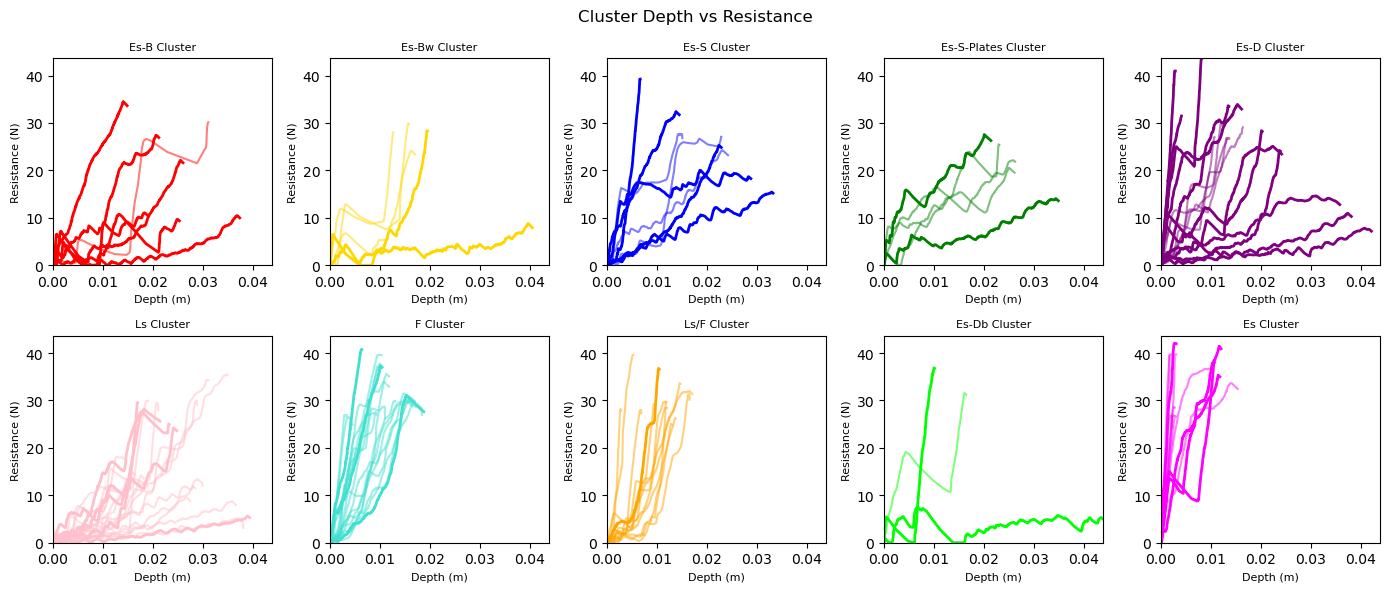

    Eigenvalue  Proportion  Cumulative
PC                                    
1     5.858204    0.386996    0.386996
2     2.957401    0.195368    0.582364
3     1.605271    0.106045    0.688409
4     1.286554    0.084991    0.773400
5     0.871551    0.057575    0.830975
6     0.793326    0.052408    0.883383
7     0.484444    0.032003    0.915385
8     0.347951    0.022986    0.938371
9     0.271373    0.017927    0.956298
10    0.197727    0.013062    0.969360
11    0.168420    0.011126    0.980486
12    0.158485    0.010470    0.990956
13    0.093465    0.006174    0.997130
14    0.030968    0.002046    0.999176
15    0.012476    0.000824    1.000000


                             PC1       PC2       PC3       PC4       PC5  \
max_depth              -0.332765 -0.203269 -0.026953 -0.184117  0.050429   
max_resistance          0.303384  0.128583  0.113806  0.435057  0.311889   
num_peaks              -0.234316 -0.099488  0.384159 -0.385283  0.269519   
largest_force_drop     -0.19913

In [130]:
def correct_pseudo_ylabels_to_actual(pseudo_labeled_data:pd.DataFrame, actual_labeled_data:pd.DataFrame, ylabel_name, changed_ylabel_idxs):
    corrected_pseudo_labeled_data = pseudo_labeled_data.copy()
    corrected_pseudo_labeled_data.loc[changed_ylabel_idxs, f'pseudo_{ylabel_name}'] = actual_labeled_data[ylabel_name]
    corrected_pseudo_labeled_data.loc[changed_ylabel_idxs, f'pseudo_{ylabel_name}_nums'] = actual_labeled_data[f'{ylabel_name}_nums']
    return corrected_pseudo_labeled_data

corrected_pseudo_labeled_data = correct_pseudo_ylabels_to_actual(pseudo_labeled_data, marions_labeled_data, ylabel_name, changed_ylabel_idxs)

plotting.plot_clusters_seperately(corrected_pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], 
                                  curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()), 
                                  pseudo_corrections=marions_labeled_data)
plotting.plot_pca(corrected_pseudo_labeled_data, corrected_pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], graph_title="Clustering Corrected Pseudo Labeled Data", num_pc=3, ylabel_name=ylabel_name, centroids=label_centroids)
plotting.pca_analysis(clustering_features)


# Plot Un-corrected Labeling

idx 1: WS23_L3_T1_P_16.csv changed label ES-B -> F
idx 16: WS23_L2_T1_P_14.csv changed label ES-S -> F
idx 17: WS23_L2_T1_P_12.csv changed label ES-S -> LS/F
idx 19: WS23_L2_T1_P_9.csv changed label ES-S -> LS
idx 21: WS23_L2_T1_P_13.csv changed label ES-D -> ES
idx 24: WS23_L2_T1_P_6.csv changed label ES-D -> LS
idx 34: WS23_L3_T1_P_17.csv changed label ES -> F
idx 36: WS23_L2_T1_P_5.csv changed label ES-D -> ES-S-Plates
idx 46: WS23_L2_T1_P_10.csv changed label ES-D -> F
idx 51: WS23_L3_T1_P_15.csv changed label ES-D -> ES
idx 55: WS23_L3_T1_P_1.csv changed label ES-B -> ES-S-Plates
idx 57: WS23_L3_T1_P_0.csv changed label LS -> ES-BW
idx 61: WS23_L2_T1_P_1.csv changed label LS -> ES-S-Plates
idx 65: WS23_L2_T1_P_3.csv changed label ES-D -> ES-S
idx 74: WS23_L3_T1_P_5.csv changed label ES-B -> ES-BW
idx 75: WS23_L2_T1_P_15.csv changed label ES-D -> ES
idx 76: WS23_L3_T1_P_14.csv changed label ES-D -> ES-BW
idx 85: WS23_L3_T1_P_23.csv changed label LS -> ES-BW
idx 86: WS23_L3_T1_P_7.c

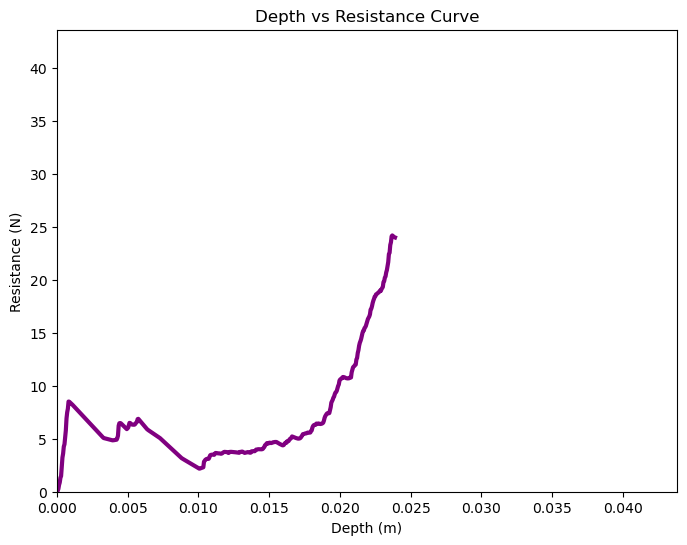

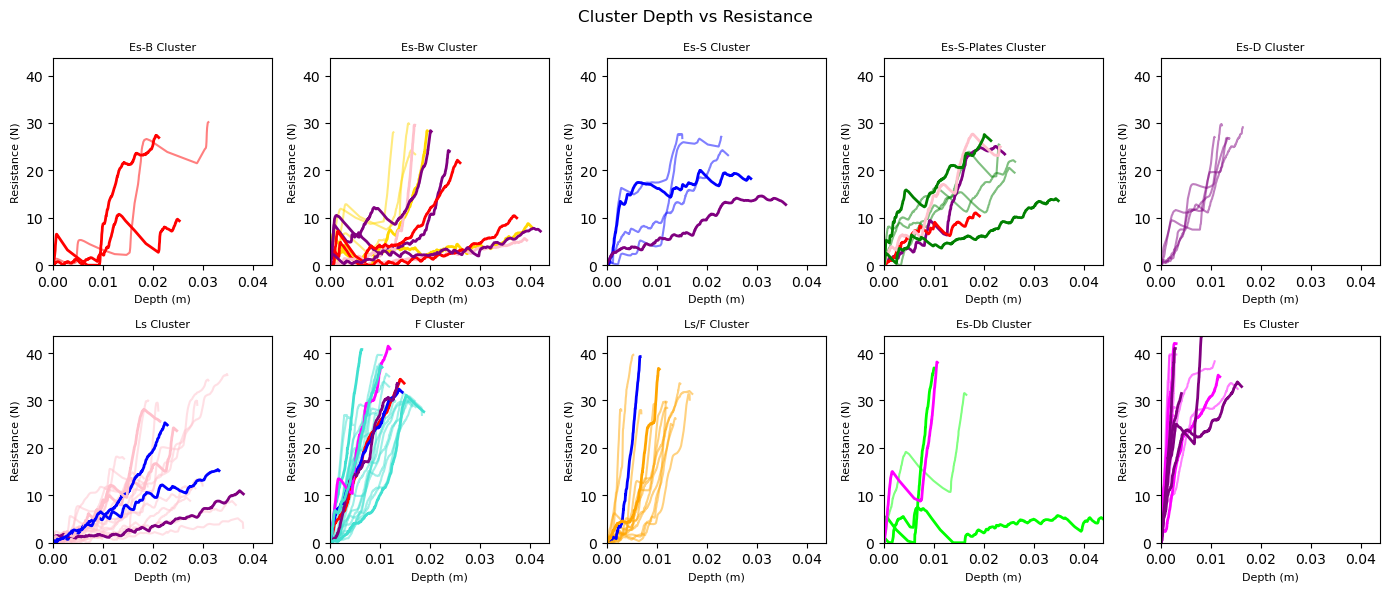

In [131]:

# plotting.get_curve_idx_from_cluster_color('red', pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], pseudo_labeled_data.index, data_features)
# plotting.get_curve_idx_from_cluster_color('gold', pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], pseudo_labeled_data.index, data_features)
# plotting.get_curve_idx_from_cluster_color('blue', pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], pseudo_labeled_data.index, data_features)

find_changed_ylabel_data(marions_labeled_data, pseudo_labeled_data, ylabel_name)
# plotting.plot_specific_curves([76], curve_data, data_features, color="purple")
plotting.plot_clusters_seperately(pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'],
                                  curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  pseudo_corrections=marions_labeled_data)
# plotting.plot_clusters_seperately(pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'],
#                                   curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()),)
# plotting.plot_clusters_seperately(pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'],
#                                   curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()),
#                                   bold_idxs=marions_labeled_data.index)
plotting.plot_pca(pseudo_labeled_data, pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], graph_title="Clustering Un-corrected Pseudo Labeled Data", num_pc=3, ylabel_name=ylabel_name, centroids=label_centroids)


# Clustering data with ES-D removed (Label Corrected to Actual)

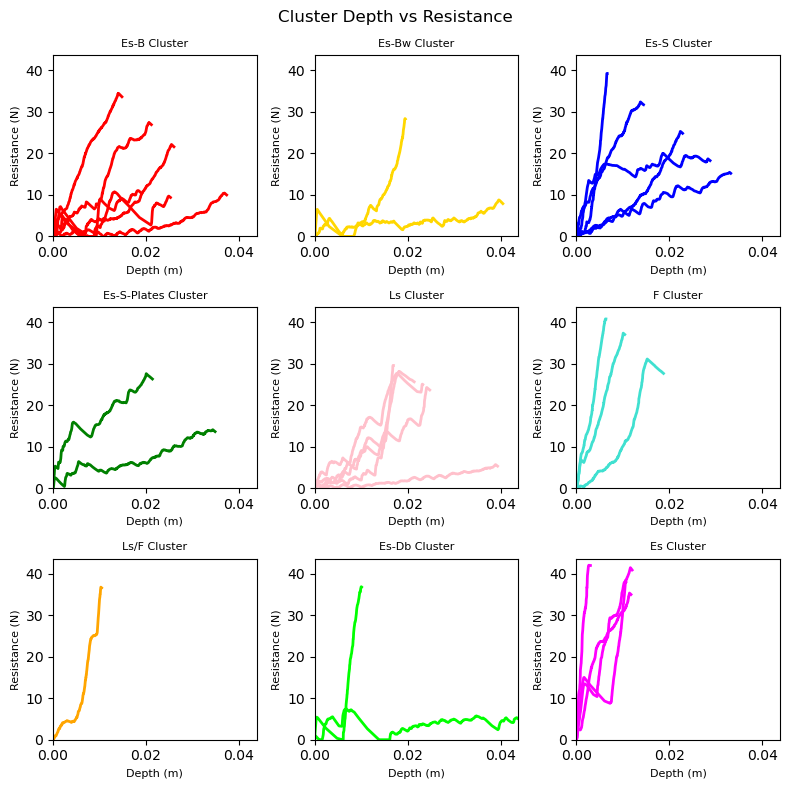

In [132]:
labeled_data_esd_removed = marions_labeled_data[marions_labeled_data[ylabel_name] != 'ES-D'].copy()
marions_labeled_data_esd_removed = marions_labeled_data[marions_labeled_data[ylabel_name] != 'ES-D']

# print('Labeled data only')
plotting.plot_clusters_seperately(labeled_data_esd_removed[f'{ylabel_name}_nums'], curve_data, 
                                  ylabel_name, bold_idxs=labeled_data_esd_removed.index.tolist(),
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()))

# Plot Pseudo Labeling w/ ES-D Removed (Pseudo Labels Corrected)

In [133]:
label_centroids_esd_removed = find_labels_centroids(labeled_data_esd_removed, ylabel_to_cluster_num, ylabel_name)
pseudo_data_esd_removed = find_closest_centroid(data_features, label_centroids_esd_removed, ylabel_name)

print('Corrected')
changed_ylabel_idxs_esd_removed = find_changed_ylabel_data(labeled_data_esd_removed, pseudo_data_esd_removed, ylabel_name)
corrected_pseudo_data_esd_removed = correct_pseudo_ylabels_to_actual(pseudo_data_esd_removed, marions_labeled_data, ylabel_name, changed_ylabel_idxs_esd_removed)
# plotting.plot_clusters_seperately(corrected_pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()), pseudo_corrections=labeled_data_esd_removed)
# plotting.plot_pca(corrected_pseudo_data_esd_removed, corrected_pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], 3, graph_title="", ylabel_name=ylabel_name, centroids=label_centroids_esd_removed)



Corrected
idx 1: WS23_L3_T1_P_16.csv changed label ES-B -> F
idx 16: WS23_L2_T1_P_14.csv changed label ES-S -> F
idx 17: WS23_L2_T1_P_12.csv changed label ES-S -> LS/F
idx 19: WS23_L2_T1_P_9.csv changed label ES-S -> LS
idx 34: WS23_L3_T1_P_17.csv changed label ES -> F
idx 55: WS23_L3_T1_P_1.csv changed label ES-B -> ES-S-Plates
idx 57: WS23_L3_T1_P_0.csv changed label LS -> ES-BW
idx 61: WS23_L2_T1_P_1.csv changed label LS -> ES-S-Plates
idx 74: WS23_L3_T1_P_5.csv changed label ES-B -> ES-BW
idx 85: WS23_L3_T1_P_23.csv changed label LS -> ES-BW
idx 86: WS23_L3_T1_P_7.csv changed label ES-B -> ES-BW
idx 95: WS23_L2_T1_P_17.csv changed label ES-S -> LS
idx 100: WS23_L3_T1_P_21.csv changed label ES -> ES-DB


# Plot Pseudo Labeling w/ ES-D Removed (Pseudo Labels Not Corrected)

Uncorrected


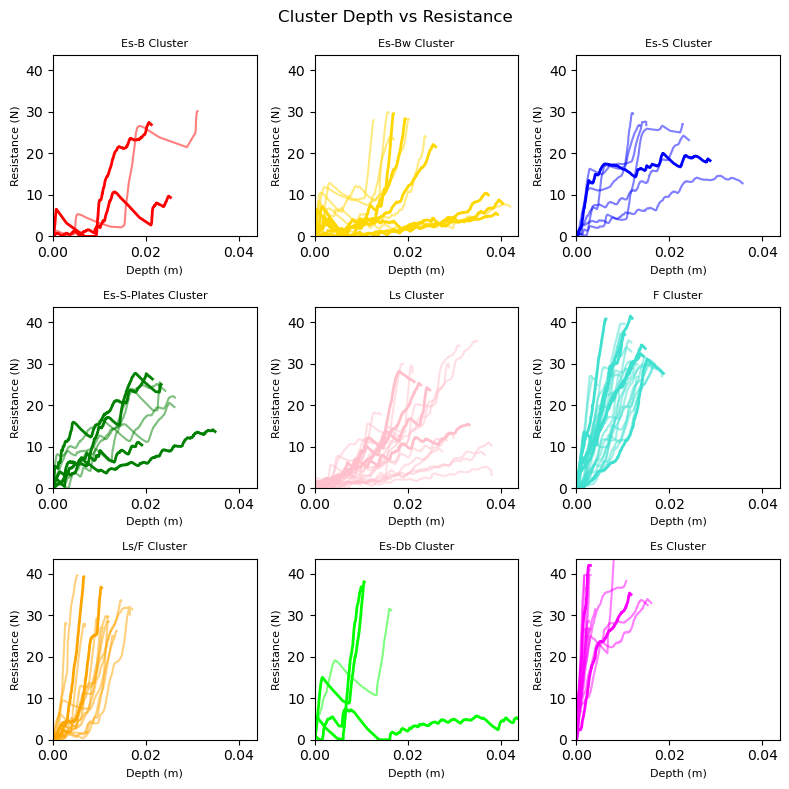

In [134]:
print('Uncorrected')
# find_changed_ylabel_data(marions_labeled_data_esd_removed, pseudo_data_esd_removed, ylabel_name)
# plotting.get_curve_idx_from_cluster_color('red', pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], pseudo_data_esd_removed.index, data_features)
# plotting.get_curve_idx_from_cluster_color('gold', pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], pseudo_data_esd_removed.index, data_features)
# plotting.get_curve_idx_from_cluster_color('blue', pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], pseudo_data_esd_removed.index, data_features)
# plotting.get_curve_idx_from_cluster_color('green', pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], pseudo_data_esd_removed.index, data_features)
# plotting.get_curve_idx_from_cluster_color('pink', pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], pseudo_data_esd_removed.index, data_features)
# plotting.get_curve_idx_from_cluster_color('turquoise', pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], pseudo_data_esd_removed.index, data_features)

plotting.plot_clusters_seperately(pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()), bold_idxs=marions_labeled_data_esd_removed.index)
# print(label_centroids_esd_removed)
plotting.plot_pca(pseudo_data_esd_removed, pseudo_data_esd_removed[f'pseudo_{ylabel_name}_nums'], 3, graph_title="", ylabel_name=ylabel_name, centroids=label_centroids_esd_removed,
                only_plot_cluster_labels=[])
# plotting.pca_analysis(pseudo_data_esd_removed)

# Plot Pseudo Labeling Steps

In [138]:
plotting.plot_pseudo_labeling_steps(corrected_pseudo_labeled_data, corrected_pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], 3, graph_title="", ylabel_name=ylabel_name, centroids=label_centroids,
                specific_clusters=[0, 9])